In [1]:
!pip install datasets evaluate transformers
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import evaluate
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Read a FASTA file and return a list of sequences.

def read_fasta(file_path):
    sequences=[]
    current_sequence=[]
    with open(file_path,"r") as file:
        for line in file:
            if line.startswith(">"):
                if current_sequence:
                    sequences.append(''.join(current_sequence))
                    current_sequence=[]
            else:
                current_sequence.append(line.strip())
        if current_sequence:
            sequences.append(''.join(current_sequence))
    return sequences

In [16]:
## Using all the sequences from the two datasets, without clustering based on sequence similarity.

# Read the sequences from the FASTA files and create DataFrames for each dataset

sequences_do = read_fasta("processed_fasta_files/mobidb_do.fasta")
sequences_dd = read_fasta("processed_fasta_files/mobidb_dd.fasta")


df_do = pd.DataFrame(sequences_do, columns=["sequence"])
df_do["label"] = 0
df_dd = pd.DataFrame(sequences_dd, columns=["sequence"])
df_dd["label"] = 1

# Calculate the length of each sequence and add it as a new column

df_do["length"] = df_do["sequence"].apply(len)
df_dd["length"] = df_dd["sequence"].apply(len)

print("mobidb_do:",df_do["length"].describe(), sep="\n")
print("mobidb_dd:",df_dd["length"].describe(), sep="\n")

# Concatenate the DataFrames

df_all = pd.concat([df_do, df_dd], ignore_index=True)

# Filter out sequences longer than 1000 characters

print("Number of removed sequences:" ,df_all[df_all["length"] > 1000]["sequence"].count())
df_all = df_all[df_all["length"] < 1001]

# Remove all sequences that are repeated more than once

sequence_counts = df_all["sequence"].value_counts()
unique_sequences = sequence_counts[sequence_counts == 1].index
df_unique = df_all[df_all["sequence"].isin(unique_sequences)].reset_index(drop=True)
print("Unique sequences count:", df_unique.shape[0])

mobidb_do:
count    14487.000000
mean        42.480155
std         88.555779
min         10.000000
25%         12.000000
50%         17.000000
75%         35.000000
max       3768.000000
Name: length, dtype: float64
mobidb_dd:
count    26074.000000
mean        46.319821
std         99.460106
min         10.000000
25%         14.000000
50%         22.000000
75%         42.000000
max       3421.000000
Name: length, dtype: float64
Number of removed sequences: 53
Unique sequences count: 39475


In [ ]:
# Load the model and tokenizer, and make predictions on the sequences

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("PLM_Sequence_LORA_Outputs/my_model_dir").to(device)
tokenizer = AutoTokenizer.from_pretrained("PLM_Sequence_LORA_Outputs/tokenizer_dir")

batch_size = 16
sequences = df_all["sequence"].tolist()
predicted_class_ids = []

from tqdm import tqdm

for i in tqdm(range(0, len(sequences), batch_size), desc="Processing batches"):
    batch = sequences[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Move input tensors to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    batch_predicted = torch.argmax(logits, dim=1).tolist()
    predicted_class_ids.extend(batch_predicted)

df_all['predicted_label'] = predicted_class_ids

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing batches: 100%|██████████| 2532/2532 [05:09<00:00,  8.18it/s]


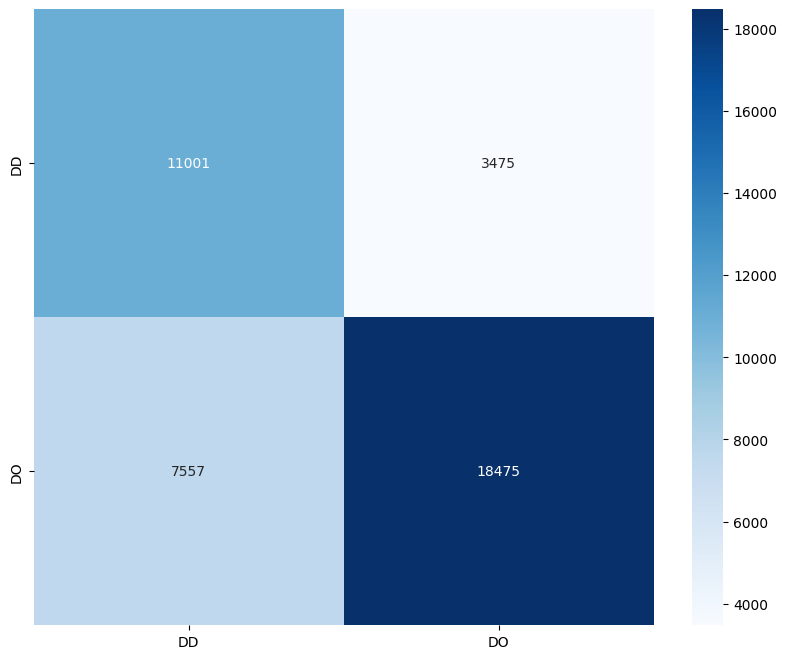

In [18]:
# Calculate and visualize the confusion matrix

confusion_matrix = evaluate.load("confusion_matrix")
results = confusion_matrix.compute(
    predictions = df_all["predicted_label"].tolist(),
    references = df_all["label"].tolist()
)

plt.figure(figsize=(10, 8))
sns.heatmap(results["confusion_matrix"], annot=True, fmt="d", cmap="Blues", xticklabels=["DD", "DO"], yticklabels=["DD", "DO"]);

In [21]:
# Calculate F1, Precision, and Recall scores
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_score = f1_metric.compute(
    predictions=df_all["predicted_label"].tolist(),
    references=df_all["label"].tolist(),
    average="weighted"
)
precision_score = precision_metric.compute(
    predictions=df_all["predicted_label"].tolist(),
    references=df_all["label"].tolist(),
    average="weighted"
)
recall_score = recall_metric.compute(
    predictions=df_all["predicted_label"].tolist(),
    references=df_all["label"].tolist(),
    average="weighted"
)

In [22]:
# Print the validation scores
print(f"F1 Score: {f1_score['f1']:.4f}")
print(f"Precision: {precision_score['precision']:.4f}")
print(f"Recall: {recall_score['recall']:.4f}")

F1 Score: 0.7329
Precision: 0.7527
Recall: 0.7277
